In [51]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
import pmdarima as pm
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

from processing import Stationarizer, Normalizer
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner, get_64_tuner

In [22]:
data = pd.read_csv("data/YF_IBM.csv")["Adj Close"]
diff = data.dropna().to_numpy().reshape((-1, 1)) #data.diff().dropna().to_numpy().reshape((-1, 1))

train_idx = int(0.7 * np.shape(diff)[0])
val_idx = int(0.85 * np.shape(diff)[0])

train_data = diff[:train_idx]
val_data = diff[train_idx:val_idx]
non_test_data = diff[:val_idx]
test_data = diff[val_idx:]

In [23]:
scaler = StandardScaler()

scaler.fit(non_test_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)

In [24]:
train_ds = timeseries_dataset_from_array(
    train_data[:-20],
    train_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=False
)
val_ds = timeseries_dataset_from_array(
    val_data[:-20],
    val_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=False
)

In [5]:
model = keras.Sequential()    
model.add(keras.Input(
      shape=(20, 1),
      batch_size=64,
      name="Inputs"
))
model.add(
    layers.LSTM(
        units=64,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.,
        recurrent_dropout=0.,
        return_sequences=True
    )
)
model.add(
    layers.LSTM(
        units=64,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.,
        recurrent_dropout=0.,
        return_sequences=False
    )
)
model.add(
    layers.Dense(
        1,
        activation="linear"
    )
)
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss="mse",
    metrics=["mse"],
)

chkpt_path = "checkpoints/model_2-1-2/model_checkpoint.weights.keras"
chkpt_cb = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=chkpt_path,
    verbose=1,
    save_best_only=True
)

es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=25)

Epoch 1/500
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1693 - mse: 0.1693
Epoch 1: val_loss improved from inf to 0.02343, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.1676 - mse: 0.1676 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0169 - mse: 0.0169
Epoch 2: val_loss improved from 0.02343 to 0.02270, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0103 - mse: 0.0103
Epoch 3: val_loss improved from 0.02270 to 0.02251, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0101 - mse: 

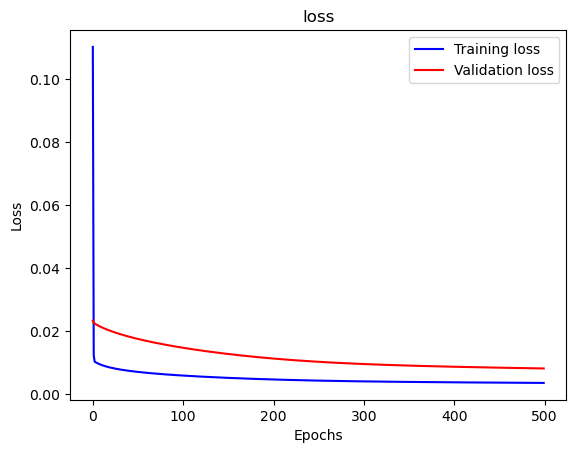

In [6]:
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=val_ds,
    callbacks=[chkpt_cb, es_cb]
)

visualize_loss(history, "loss")

In [ ]:
model.load_weights()

In [7]:
preds = []

for x, y in val_ds:
    yhat = model.predict(x)
    for el in range(x.shape[0]):
        preds.append([x[el], y[el], yhat[el]])
    
preds[0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


2024-08-09 20:45:13.339329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
 array([[1.53948556],
        [1.54965541],
        [1.60123244],
        [1.56684676],
        [1.55522458],
        [1.56539416],
        [1.56321512],
        [1.54069692],
        [1.48573003],
        [1.50146851],
        [1.46829609],
        [1.45037695],
        [1.45255788],
        [1.48718237],
        [1.44868175],
        [1.44989338],
        [1.40582358],
        [1.42761534],
        [1.42858383],
        [1.40461331]])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.40315908])>,
 array([1.4130204], dtype=float32)]

In [8]:
y = np.array([float(el[1]) for el in preds]).reshape((-1, 1))
yhat = np.array([float(el[2]) for el in preds]).reshape((-1, 1))

y_r = scaler.inverse_transform(y)
yhat_r = scaler.inverse_transform(yhat)

y_r = y_r.flatten()
yhat_r = yhat_r.flatten()

(0.0, 150.0)

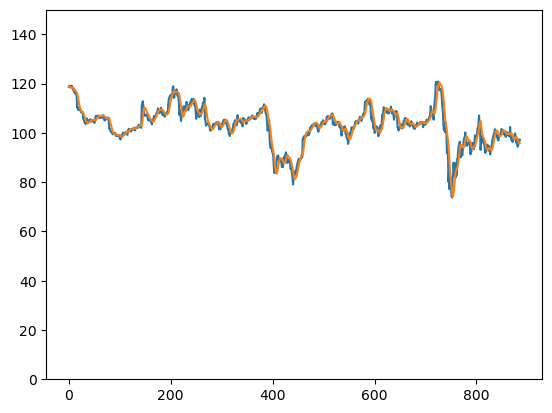

In [9]:
plt.plot(np.arange(y_r.shape[0]), y_r)
plt.plot(np.arange(yhat_r.shape[0]), yhat_r)
plt.ylim((0, 150))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

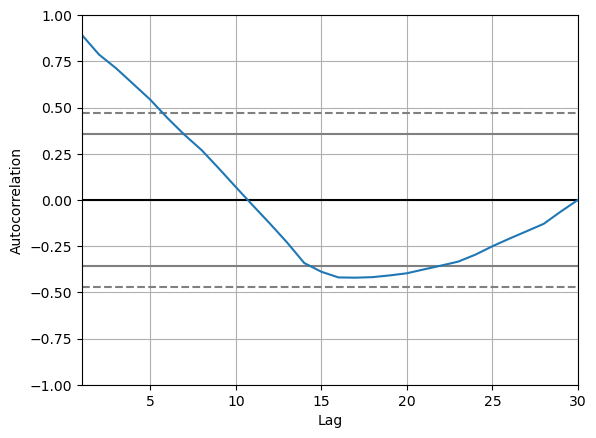

In [55]:
sta = data.diff().dropna().to_numpy().reshape((-1, 1))
sc = StandardScaler()
scsta = sc.fit_transform(sta)
#plt.plot(np.arange(sta.shape[0]), sta)
autocorrelation_plot(y_r[:30])

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6164
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10486.124
Date:                Sat, 10 Aug 2024   AIC                          20984.249
Time:                        14:48:02   BIC                          21024.607
Sample:                             0   HQIC                         20998.245
                               - 6164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0217      0.009     -2.438      0.015      -0.039      -0.004
ar.L2         -0.0005      0.009     -0.057      0.954      -0.017       0.016
ar.L3          0.0004      0.009      0.047      0.9

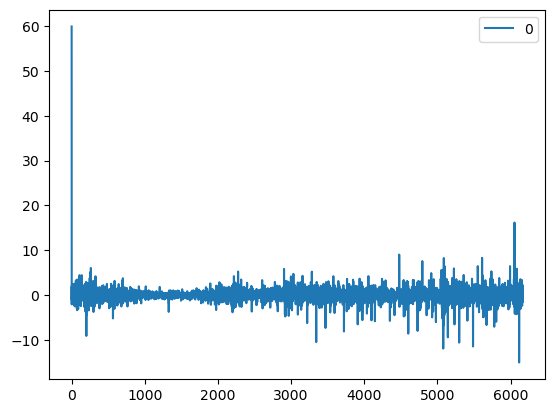

In [56]:
# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

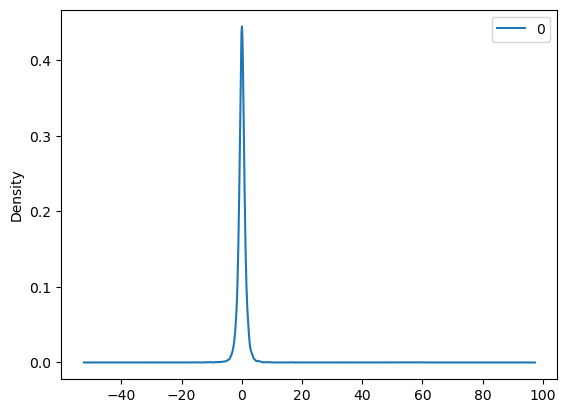

                 0
count  6164.000000
mean      0.028799
std       1.529874
min     -14.988611
25%      -0.569174
50%       0.032143
75%       0.627490
max      59.880375


In [57]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())